In [85]:
import numpy as np
import pandas as pd

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

import dill


In [27]:
df = pd.read_csv('heart.csv')
df.sample(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
211,50,F,NAP,140,288,0,Normal,140,Y,0.0,Flat,1
499,62,M,ASY,135,297,0,Normal,130,Y,1.0,Flat,1
837,57,M,NAP,150,168,0,Normal,174,N,1.6,Up,0
452,60,M,ASY,140,281,0,ST,118,Y,1.5,Flat,1
587,37,M,NAP,118,240,0,LVH,165,N,1.0,Flat,0


### EDA

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


**Age**: age of the patient [years]\
**Sex**: sex of the patient [M: Male, F: Female]/
ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]\
**estingRBP**: resting blood pressure [mm Hg]\
**Cholesterol**: serum cholesterol [mm/dl]\
**FastingBS**: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
**RestingECG**: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]\
**MaxHR**: maximum heart rate achieved [Numeric value between 60 and 202]\
**ExerciseAngina**: exercise-induced angina [Y: Yes, N: No]\
**Oldpeak**: oldpeak = ST [Numeric value measured in depression]\
**ST_Slope**: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]\
**HeartDisease**: output class [1: heart disease, 0: Normal]

In [29]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


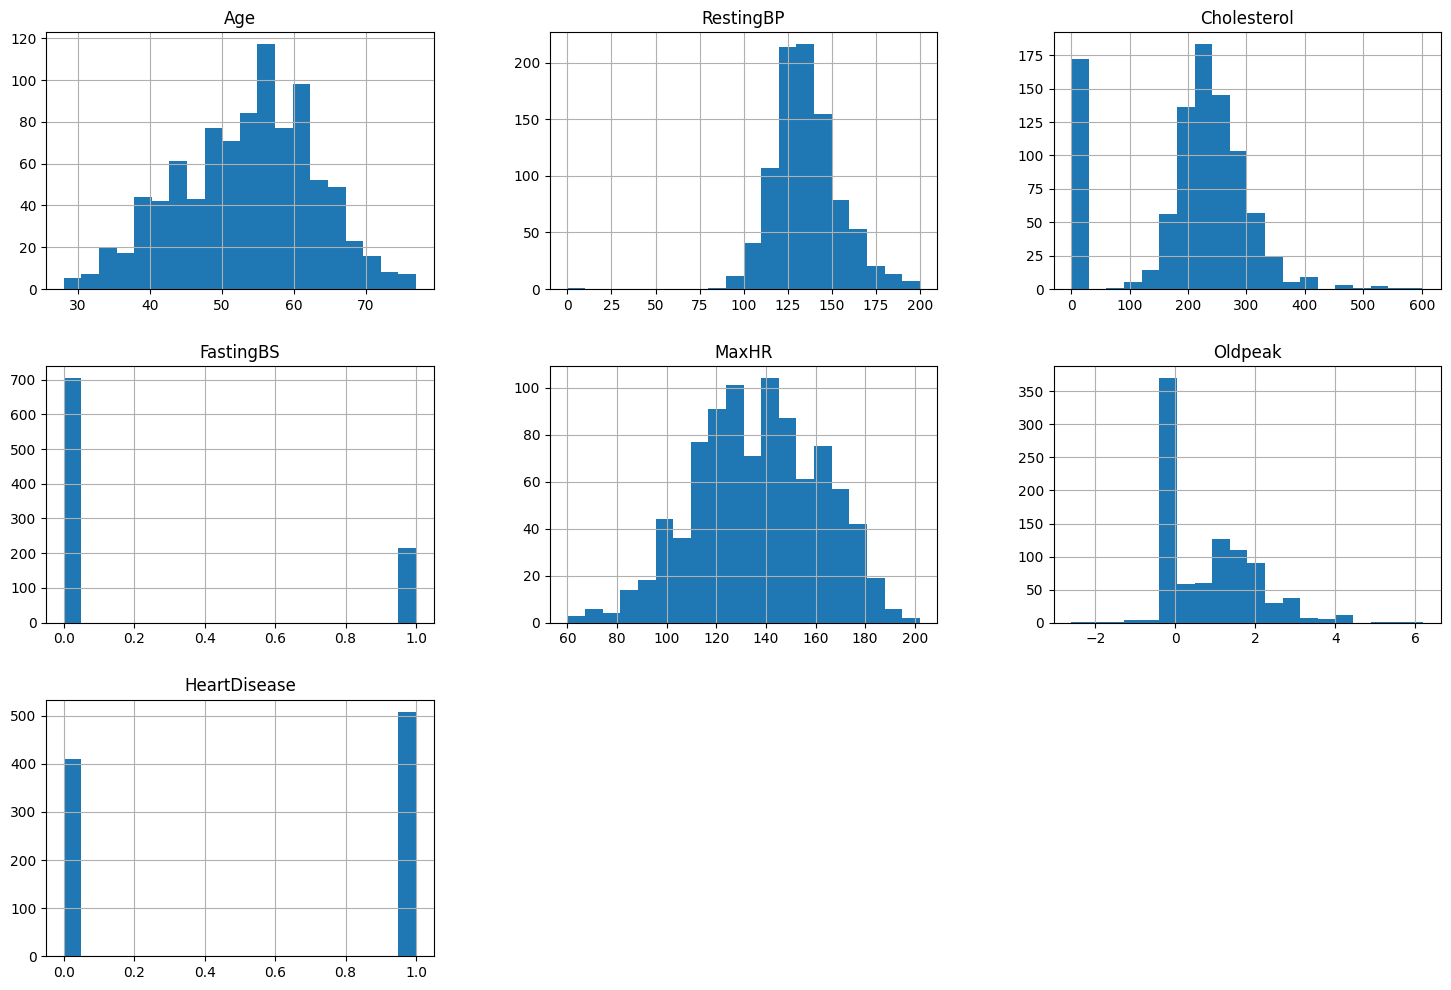

In [30]:
df.hist(bins=20, figsize=(18, 12));

In [31]:
df['HeartDisease'].value_counts()

1    508
0    410
Name: HeartDisease, dtype: int64

In [86]:
continuos_cols = ['Age' ,'RestingBP' ,'Cholesterol' ,'MaxHR' ,'Oldpeak']
cat_cols = ['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope']
base_cols = ['FastingBS']

### FE

In [87]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='HeartDisease'), 
                                      df['HeartDisease'], 
                                      test_size=0.3, random_state=42)

In [88]:
#save test
X_test.to_csv("X_test.csv", index=None)
y_test.to_csv("y_test.csv", index=None)
#save train
X_train.to_csv("X_train.csv", index=None)
y_train.to_csv("y_train.csv", index=None)

In [169]:


class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]


In [170]:
continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [171]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[ 0.46471433, -1.77231378,  0.2949892 , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.78176703, -1.23486848, -1.90539005, ...,  0.        ,
         0.        ,  1.        ],
       [-0.06370685,  1.45235803, -1.90539005, ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [ 0.6760828 , -0.15997788,  0.47365248, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.6760828 ,  1.02240179, -1.90539005, ...,  0.        ,
         1.        ,  0.        ],
       [-1.43760192,  0.91491273,  1.78071537, ...,  1.        ,
         0.        ,  0.        ]])

In [172]:
%%time

pipeline = Pipeline([
    ('features',feats),
    ('classifier', XGBClassifier(random_state=42)),
])

pipeline.fit(X_train, y_train)

CPU times: user 410 ms, sys: 36 ms, total: 446 ms
Wall time: 186 ms


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Age',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Age')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('RestingBP',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='RestingBP')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('Cholesterol',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Cholesterol')),
                                                                 ('standard'...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=42, ...))])

In [173]:
with open("xgb_clsf_pipeline.dill", "wb") as f:
    dill.dump(pipeline, f)